In [1]:
from matplotlib import pyplot as plt
from balsam.api import Job
from balsam.analytics import throughput_report, utilization_report
from pathlib import Path
import pickle
from datetime import datetime, timedelta

import seaborn as sns
sns.set_context('paper')


WARNING|balsam.api:23] balsam.api failed to auto-load Client:
Client credentials /homes/abrace/.balsam/client.yml do not exist. Please authenticate with `balsam login`.


In [2]:
experiments = ["perlmutter-production-final", "production-cross2", "production-thetagpu-0"]

experiment_dirs = {exp: Path("paper-summary/") / exp for exp in experiments}

events = {}

for exp in experiments:
    events[exp] = pickle.load(open(experiment_dirs[exp] / "events.pkl", 'rb'))

In [3]:
events.keys()

dict_keys(['perlmutter-production-final', 'production-cross2', 'production-thetagpu-0'])

In [4]:
def throughput(events_list, to_state="RUN_DONE", t0: datetime = None):
    """
    If t0 is not None, return times as elapsed minutes since t0.  
    Otherwise t0 is set to the earliest event in the events_list.
    """
    events = [e for e in events_list if e.to_state == to_state]
    events = sorted(events, key = lambda evt: evt.timestamp)
    
    times = [e.timestamp for e in events]
    
    if t0 is None:
        t0 = min(times)
        
    elapsed_minutes = [(t - t0).total_seconds() / 60.0 for t in times]

    counts = list(range(1, len(times) + 1))
    
    return elapsed_minutes, counts

Text(0, 0.5, 'Completed NAMD Restarts')

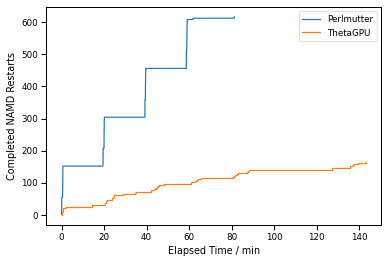

In [5]:
time_series_tuple = throughput(events["production-cross2"]["namd_perlmutter"])
fig, ax = plt.subplots()
ax.step(*time_series_tuple, where="post", label="Perlmutter")

time_series_tuple = throughput(events["production-cross2"]["namd_thetagpu"])
ax.step(*time_series_tuple, where="post", label="ThetaGPU")
ax.legend()

ax.set_xlabel("Elapsed Time / min")
ax.set_ylabel("Completed NAMD Restarts")

In [6]:
from itertools import accumulate # cumulative summation

def utilization(events, node_weighting: bool = True, t0 = None):
    job_events = []
    nodes_by_id: Dict[int, float] = {}
        
    for evt in [e for e in events if e.to_state=="RUNNING"]:
        usage_count = evt.data["num_nodes"] if node_weighting else 1.0
        nodes_by_id[evt.job_id] = usage_count
        job_events.append((evt.timestamp, usage_count))
        
    for evt in [e for e in events if e.from_state=="RUNNING"]:
        job_events.append((evt.timestamp, -1.0 * nodes_by_id.get(evt.job_id, 1.0)))

    times, counts = zip(*sorted(job_events))
    times = list(times)
    utilizations = list(accumulate(counts))
    
    if t0 is None:
        t0 = min(times)
        
    elapsed_minutes = [(t - t0).total_seconds() / 60.0 for t in times]
    
    return elapsed_minutes, utilizations

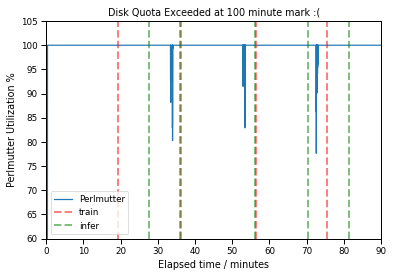

In [7]:

# When node_weighting=True each Perlmutter job counts as 1/4 of a node (cause packing count is 4):

namd_evts = events["production-cross2"]["namd_perlmutter"]
t0 = min(e.timestamp for e in namd_evts)

times, util_counts = utilization(namd_evts, t0=t0, node_weighting=True)

node_total = 38.0 # we had 38 nodes for this run
util_percentage = [100 * c / node_total for c in util_counts]

fig, ax = plt.subplots()
ax.step(times, util_percentage, where="post", label="Perlmutter")

ax.set_title("Disk Quota Exceeded at 100 minute mark :(")
ax.set_xlabel("Elapsed time / minutes")
ax.set_ylabel("Perlmutter Utilization %")
ax.set_xlim(0, 90)
ax.set_ylim(60, 105)


train_starts = [e.timestamp for e in events["production-cross2"]["anca_ae_train_namd"] if e.to_state == "RUNNING"]
train_starts = [(t - t0).total_seconds() / 60.0 for t in train_starts]

infer_starts = [e.timestamp for e in events["production-cross2"]["anca_ae_infer_namd"] if e.to_state == "RUNNING"]
infer_starts = [(t - t0).total_seconds() / 60.0 for t in infer_starts]

for i, t in enumerate(train_starts):
    label = {"label": "train"} if i == 0 else {}
    ax.axvline(x=t, color='r', alpha=0.5, lw=2, ls='--', **label)
    
for i, t in enumerate(infer_starts):
    label = {"label": "infer"} if i == 0 else {}
    ax.axvline(x=t, color='g', alpha=0.5, lw=2, ls='--', **label)
    
ax.legend()

In [8]:
ax.axvline()